# Predicting Tornado Injuries

## Import Statements

In [1]:
import pandas as pd                  # Pandas
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor # Decision Tree
from xgboost import XGBRegressor, XGBClassifier  # XG Boost

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Import packages to implement Stratified K-fold CV
from sklearn.model_selection import StratifiedKFold # For creating folds

# Import Package to implement GridSearch CV (Hyperparameter Tuning Method 1)
from sklearn.model_selection import GridSearchCV

# Importing package for Randomized Search CV (Hyperparameter Tuning Method 2)
from sklearn.model_selection import RandomizedSearchCV

# Package for generating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Package for generating classification report
from sklearn.metrics import classification_report

# Time packages
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import seaborn as sns

## Importing Data

In [3]:
# Import Data from years 2018, 2021, 2022, 2023

storm_locations_2023_df = pd.read_csv('StormEvents_locations-ftp_v1.0_d2023_c20231017.csv')
storm_locations_2023_df.head()
storm_details_2023_df = pd.read_csv('StormEvents_details-ftp_v1.0_d2023_c20231017.csv')
storm_details_2023_df.head()

storm_2023_df = storm_locations_2023_df.merge(storm_details_2023_df, how="left", left_on='EVENT_ID', right_on='EVENT_ID')

storm_details_2022_df = pd.read_csv('StormEvents_details-ftp_v1.0_d2022_c20231116.csv')
storm_locations_2022_df = pd.read_csv('StormEvents_locations-ftp_v1.0_d2022_c20231116.csv')
storm_2022_df = storm_locations_2022_df.merge(storm_details_2022_df, how="left", left_on='EVENT_ID', right_on='EVENT_ID')

storm_locations_2021_df = pd.read_csv('StormEvents_locations-ftp_v1.0_d2021_c20231017.csv')
storm_details_2021_df = pd.read_csv('StormEvents_details-ftp_v1.0_d2021_c20231017.csv')
storm_2021_df = storm_locations_2021_df.merge(storm_details_2021_df, how="left", left_on='EVENT_ID', right_on='EVENT_ID')

storm_locations_2018_df = pd.read_csv('StormEvents_locations-ftp_v1.0_d2018_c20230616.csv')
storm_details_2018_df = pd.read_csv('StormEvents_details-ftp_v1.0_d2018_c20230616.csv')
storm_2018_df = storm_locations_2018_df.merge(storm_details_2018_df, how="left", left_on='EVENT_ID', right_on='EVENT_ID')

In [4]:
# subset to tornados only
tornado_2023_df = storm_2023_df[storm_2023_df["EVENT_TYPE"] == "Tornado"]
tornado_2023_df = tornado_2023_df.drop_duplicates(subset=['EVENT_ID'])

tornado_2022_df = storm_2022_df[storm_2022_df["EVENT_TYPE"] == "Tornado"]
tornado_2022_df = tornado_2022_df.drop_duplicates(subset=['EVENT_ID'])

tornado_2021_df = storm_2021_df[storm_2021_df["EVENT_TYPE"] == "Tornado"]
tornado_2021_df = tornado_2021_df.drop_duplicates(subset=['EVENT_ID'])

tornado_2018_df = storm_2018_df[storm_2018_df["EVENT_TYPE"] == "Tornado"]
tornado_2018_df = tornado_2018_df.drop_duplicates(subset=['EVENT_ID'])



In [5]:
# Add all datsets together
tornado_df = pd.concat([tornado_2023_df, tornado_2022_df, tornado_2021_df, tornado_2018_df])

tornado_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3981 entries, 90 to 73433
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YEARMONTH           3981 non-null   int64  
 1   EPISODE_ID_x        3981 non-null   int64  
 2   EVENT_ID            3981 non-null   int64  
 3   LOCATION_INDEX      3981 non-null   int64  
 4   RANGE               3981 non-null   float64
 5   AZIMUTH             3981 non-null   object 
 6   LOCATION            3981 non-null   object 
 7   LATITUDE            3981 non-null   float64
 8   LONGITUDE           3981 non-null   float64
 9   LAT2                3981 non-null   int64  
 10  LON2                3981 non-null   int64  
 11  BEGIN_YEARMONTH     3981 non-null   float64
 12  BEGIN_DAY           3981 non-null   float64
 13  BEGIN_TIME          3981 non-null   float64
 14  END_YEARMONTH       3981 non-null   float64
 15  END_DAY             3981 non-null   float64
 16  END_

## Data Cleaning

In [6]:
# Convert date_time column to datetime object
tornado_df['BEGIN_DATE_TIME'] = tornado_df['BEGIN_DATE_TIME'].apply(pd.to_datetime)
tornado_df['END_DATE_TIME'] = tornado_df['END_DATE_TIME'].apply(pd.to_datetime)
tornado_df['TIME_ELAPSED'] = tornado_df['END_DATE_TIME'] - tornado_df['BEGIN_DATE_TIME']

# convert time delta to minutes
tornado_df['TIME_ELAPSED'] = tornado_df['TIME_ELAPSED'].astype('timedelta64[m]')

# find range of tornado from lat & lon
tornado_df['VERTICAL_MOVEMENT'] = abs(tornado_df['BEGIN_LAT'] - tornado_df['END_LAT'])
tornado_df['HORIZONTAL_MOVEMENT'] = abs(tornado_df['BEGIN_LON'] - tornado_df['END_LON'])


In [6]:
# change property and crop damage column from string to numeric
def convert_to_numeric(value):
  value = str(value).lower()
  if 'k' in value:
      return float(value.replace('k', '')) * 1000
  elif 'm' in value:
      return float(value.replace('m', '')) * 1000000
  else:
      return float(value)

# Apply the conversion function to the column
tornado_df['DAMAGE_PROPERTY'] = tornado_df['DAMAGE_PROPERTY'].apply(convert_to_numeric)
tornado_df['DAMAGE_CROPS'] = tornado_df['DAMAGE_CROPS'].apply(convert_to_numeric)


In [7]:
# Making injuries into a classifier
tornado_df['INJURIES_BINARY'] = tornado_df.apply(lambda x: 'Injuries' if x['INJURIES_DIRECT'] > 0 else 'No Injuries', axis = 1)

tornado_df['INJURIES_CLASS'] = tornado_df['INJURIES_DIRECT'].apply(lambda x: 0 if x == 0 else (1 if 1 <= x <= 5 else 2))



In [8]:
tornado_df.shape

(3981, 66)

## Data Exploration

In [ ]:
# check correlations
tornado_df[['BEGIN_DAY', 'BEGIN_TIME', 'STATE',  'YEAR',
       'MONTH_NAME', 'CZ_NAME', 'WFO',
       'INJURIES_DIRECT', 
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
       'TOR_F_SCALE', 
       'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']].dropna()

In [12]:
tornado_df[['BEGIN_DAY', 'BEGIN_TIME', 'STATE',  'YEAR',
       'MONTH_NAME', 'CZ_NAME', 'WFO',
       'INJURIES_CLASS', 
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
       'TOR_F_SCALE', 
       'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']].dropna().groupby(by = 'INJURIES_CLASS').mean()

,BEGIN_DAY,BEGIN_TIME,YEAR,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,TIME_ELAPSED,VERTICAL_MOVEMENT,HORIZONTAL_MOVEMENT
INJURIES_CLASS,,,,,,,,,,,,
0,15.832930,1503.890349,2020.584573,2.657212,160.073217,37.280472,-91.593362,37.295792,-91.558577,4.827395,0.020627,0.035947
1,16.257143,1354.285714,2020.857143,7.370762,442.933333,34.348404,-88.343856,34.402694,-88.242519,10.600000,0.057167,0.101739
2,15.468750,1553.156250,2021.000000,11.483437,673.312500,35.460413,-90.464522,35.554834,-90.307766,15.812500,0.103078,0.157575


In [15]:
tornado_df[['BEGIN_DAY', 'BEGIN_TIME', 'STATE',  'YEAR',
       'MONTH_NAME', 'CZ_NAME', 'WFO',
       'INJURIES_CLASS', 
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
       'TOR_F_SCALE', 
       'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']].dropna().groupby(by = 'INJURIES_CLASS')['MONTH_NAME'].value_counts()

INJURIES_CLASS  MONTH_NAME
0               May           568
                June          380
                April         346
                March         320
                July          271
                December      222
                October       176
                August        157
                November      152
                September     117
                February       96
                January        86
1               March          23
                April          22
                February        9
                May             9
                November        9
                December        8
                January         8
                October         7
                September       5
                August          2
                June            2
                July            1
2               March           6
                July            5
                June            5
                December        4
                Novem

In [25]:
# check correlations
tornado_df[['BEGIN_DAY', 'BEGIN_TIME', 'STATE',  'YEAR',
       'MONTH_NAME', 'CZ_NAME', 'WFO',
       'INJURIES_DIRECT', 
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
       'TOR_F_SCALE', 
       'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']].dropna().corr()[['INJURIES_DIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS']]

,INJURIES_DIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS
BEGIN_DAY,0.000806,-0.010798,-0.029863
BEGIN_TIME,0.006769,-0.015447,-0.011615
YEAR,0.011747,0.003643,-0.030282
INJURIES_DIRECT,1.000000,0.446503,-0.003837
DAMAGE_PROPERTY,0.446503,1.000000,0.004767
DAMAGE_CROPS,-0.003837,0.004767,1.000000
TOR_LENGTH,0.234284,0.088053,0.031800
TOR_WIDTH,0.201844,0.106435,0.015538
BEGIN_LAT,-0.029335,-0.001922,0.037712
BEGIN_LON,0.028715,0.031977,-0.040130


In [9]:
tornado_df['YEAR'].value_counts()

2018.0    1253
2021.0    1161
2022.0     789
2023.0     778
Name: YEAR, dtype: int64

In [26]:
tornado_df['INJURIES_DIRECT'].value_counts()

0.0      3797
1.0        63
2.0        42
3.0        13
5.0        12
4.0        10
6.0         7
8.0         7
7.0         6
10.0        4
16.0        2
30.0        2
22.0        2
11.0        2
13.0        1
9.0         1
17.0        1
63.0        1
15.0        1
44.0        1
14.0        1
23.0        1
12.0        1
100.0       1
54.0        1
28.0        1
Name: INJURIES_DIRECT, dtype: int64

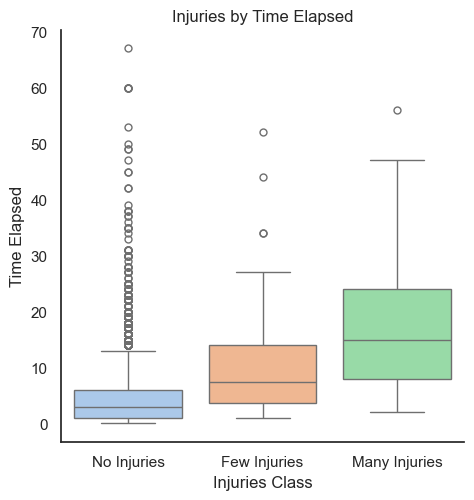

In [57]:
plot = sns.catplot(data=tornado_df, x="INJURIES_CLASS", y='TIME_ELAPSED', kind = "box", palette="pastel")

plt.xlabel("Injuries Class")
plt.ylabel("Time Elapsed")
plt.title("Injuries by Time Elapsed")
plot.set_xticklabels(["No Injuries", "Few Injuries", "Many Injuries"])
plot._legend.remove()
plt.show();

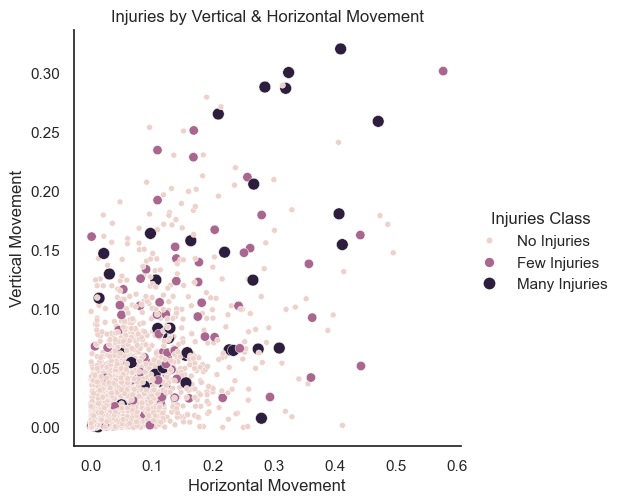

In [59]:
plot = sns.relplot(
    data=tornado_df, x="HORIZONTAL_MOVEMENT", y="VERTICAL_MOVEMENT", hue="INJURIES_CLASS", size = "INJURIES_CLASS"
)

plt.xlabel("Horizontal Movement")
plt.ylabel("Vertical Movement")
plot._legend.set_title("Injuries Class")
# replace labels
new_labels = ["No Injuries", "Few Injuries", "Many Injuries"]
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.title("Injuries by Vertical & Horizontal Movement")
plt.show();


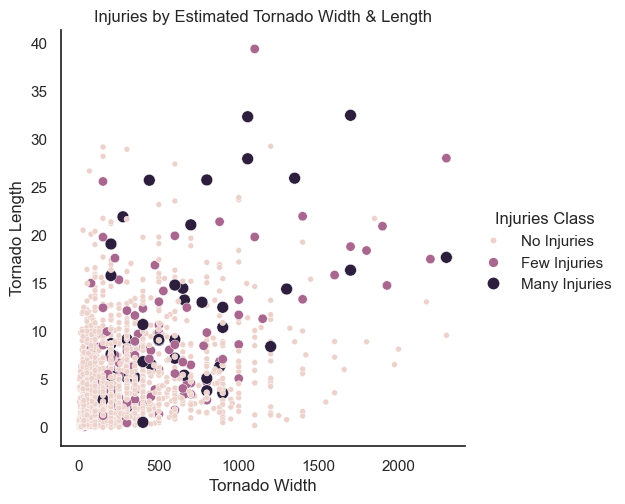

In [60]:
plot = sns.relplot(
    data=tornado_df, x="TOR_WIDTH", y="TOR_LENGTH", hue="INJURIES_CLASS", size = "INJURIES_CLASS"
)

plt.xlabel("Tornado Width")
plt.ylabel("Tornado Length")
plot._legend.set_title("Injuries Class")
# replace labels
new_labels = ["No Injuries", "Few Injuries", "Many Injuries"]
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.title("Injuries by Estimated Tornado Width & Length")
plt.show();


In [27]:
month_df = tornado_df.groupby(by = ["INJURIES_CLASS", 'MONTH_NAME'])['TOR_WIDTH'].mean().to_frame().reset_index()

In [41]:
month_df

,INJURIES_CLASS,MONTH_NAME,TOR_WIDTH
0,0,April,181.473885
1,0,August,99.158371
2,0,December,150.912752
3,0,February,171.971154
4,0,January,144.572464
5,0,July,115.952514
6,0,June,121.484663
7,0,March,262.460976
8,0,May,123.736278
9,0,November,275.137363


In [39]:
y0 = month_df[month_df['INJURIES_CLASS'] == 0]['TOR_WIDTH']
y1 = month_df[month_df['INJURIES_CLASS'] == 1]['TOR_WIDTH']
#y2 = month_df[month_df['INJURIES_CLASS'] == 2]['TOR_WIDTH']

x = month_df['MONTH_NAME'].value_counts().index.to_list()

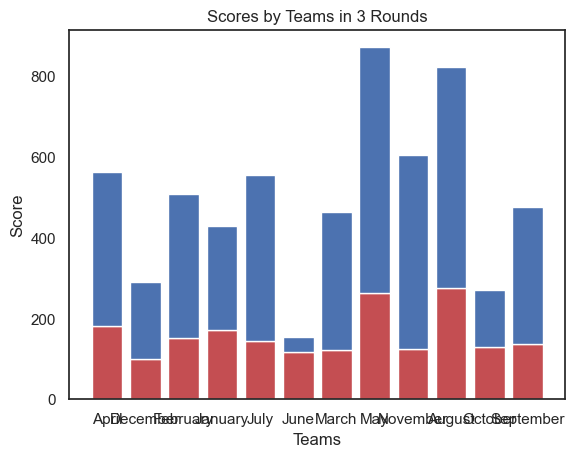

In [42]:
# plot bars in stack manner
plt.bar(x, y0, color='r')
plt.bar(x, y1, bottom=y0, color='b')
#plt.bar(x, y2, bottom=y0+y1, color='y')
plt.xlabel("Tor Height")
plt.ylabel("Tor Width")
#plt.legend(["Round 1", "Round 2", "Round 3"])
#plt.title("Scores by Teams in 3 Rounds")
plt.show()


<AxesSubplot: xlabel='INJURIES_CLASS'>

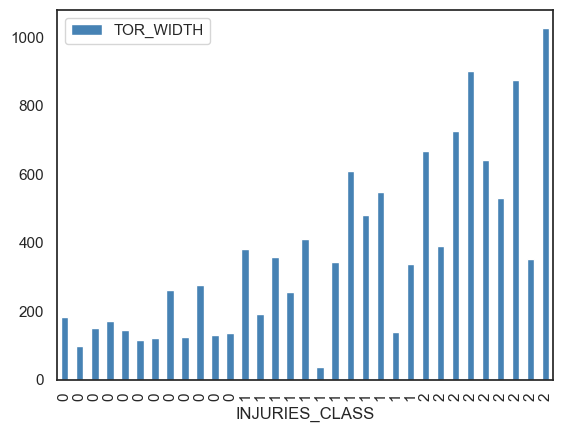

In [28]:
#set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
month_df.set_index('INJURIES_CLASS').plot(kind='bar', stacked=True, color=['steelblue', 'red'])

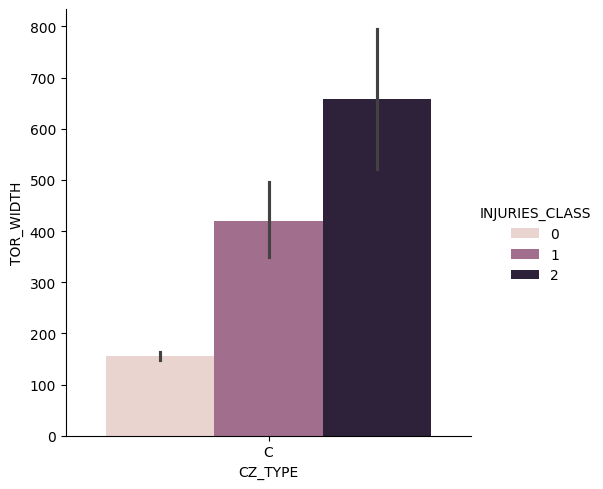

In [17]:
sns.catplot(data=tornado_df, x='MONTH_NAME', y="TOR_WIDTH", hue="INJURIES_CLASS", kind="bar")

## Tornados Injuries Prediction

In [61]:
df_injuries = tornado_df[['BEGIN_DAY', 'BEGIN_TIME', 'STATE',  'YEAR',
       'MONTH_NAME', 'CZ_TYPE', 'CZ_NAME', 'WFO',
       'INJURIES_CLASS', 
  #   'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
  #     'TOR_F_SCALE', 
       'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']]


# drop NA values
df_injuries.dropna(inplace=True)

df_injuries.shape

(3981, 19)

In [63]:
df_injuries['INJURIES_CLASS'].value_counts()

0    3797
1     140
2      44
Name: INJURIES_CLASS, dtype: int64

In [64]:
# set target variable
X = df_injuries.drop(columns = ['INJURIES_CLASS'])
y = df_injuries['INJURIES_CLASS']

# encode categorical variables
cat_var = ['STATE', 'MONTH_NAME', 'CZ_TYPE', 'CZ_NAME', 'WFO','SOURCE']#, 'TOR_F_SCALE']
X_encoded = pd.get_dummies(X, columns = cat_var)

# split train/test dataset
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.3, random_state = 1)

# Creating folds
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 100)

In [65]:
# set class name
uniques = pd.Index(['No Injuries', 'A Few Injuries', 'Many Injuries'])

### XGBoost: Stratified K-fold CV w/ Tuning

In [66]:
# Define model algorithm
XGClassifier = XGBClassifier(random_state = 42)

##### Tuning n estimators, min child weight, max depth

In [67]:
random_grid = {
    'max_depth': list(range(2,30,2)),
    'min_child_weight':list(range(1,60, 2)),
    'n_estimators': list(range(2, 30, 2))
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGClassifier, 
                                param_distributions = random_grid, 
                                n_iter = 40,
                                scoring='precision_weighted',
                                n_jobs=4,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59], 'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]}


In [68]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 41.60915470123291s
Initial score:  0.9241818278601427
Initial parameters:  {'n_estimators': 14, 'min_child_weight': 3, 'max_depth': 6}


In [69]:
random_grid = {
    'max_depth': list(range(2, 12)),
    'min_child_weight':list(range(1,8)),
    'n_estimators': list(range(10, 26, 2))
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGClassifier, 
                                param_distributions = random_grid, 
                                n_iter = 40,
                                scoring='precision_weighted',
                                n_jobs=4,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'min_child_weight': [1, 2, 3, 4, 5, 6, 7], 'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24]}


In [70]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 43.85452342033386s
Initial score:  0.9310698664570821
Initial parameters:  {'n_estimators': 18, 'min_child_weight': 1, 'max_depth': 9}


##### Tuning gamma and learning rate

In [75]:
random_grid = {
    'max_depth': list(range(8, 16)),
    'min_child_weight':list(range(1, 5)),
    'n_estimators': list(range(12, 24, 2)),
    'gamma': list(range(0,10)),    
    'learning_rate': [i/10.0 for i in range(1,11)]
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGClassifier, 
                                param_distributions = random_grid, 
                                n_iter = 80,
                                scoring='precision_weighted',
                                n_jobs=-1,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [8, 9, 10, 11, 12, 13, 14, 15], 'min_child_weight': [1, 2, 3, 4], 'n_estimators': [12, 14, 16, 18, 20, 22], 'gamma': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


In [76]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 33.35981345176697s
Initial score:  0.9288889994361327
Initial parameters:  {'n_estimators': 20, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.4, 'gamma': 2}


In [77]:
pd.DataFrame(xg_model_cv.cv_results_).sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,1.691436,0.026792,0.377781,0.015621,20,2,8,0.4,2,"{'n_estimators': 20, 'min_child_weight': 2, 'm...",0.928218,0.946072,0.912377,0.928889,0.013764,1
1,2.194861,0.015434,0.378102,0.014499,16,4,11,0.5,0,"{'n_estimators': 16, 'min_child_weight': 4, 'm...",0.940685,0.927449,0.917964,0.928700,0.009318,2
2,1.651828,0.022489,0.386386,0.011556,16,3,8,0.9,2,"{'n_estimators': 16, 'min_child_weight': 3, 'm...",0.937097,0.928264,0.911108,0.925490,0.010790,3
78,1.496056,0.087858,0.319106,0.012780,12,1,11,0.4,1,"{'n_estimators': 12, 'min_child_weight': 1, 'm...",0.946025,0.916236,0.913186,0.925149,0.014814,4
51,2.102600,0.037321,0.386130,0.004531,14,3,10,0.6,0,"{'n_estimators': 14, 'min_child_weight': 3, 'm...",0.934721,0.921453,0.918012,0.924729,0.007204,5


In [81]:
random_grid = {
    'max_depth': list(range(8, 13)),
    'min_child_weight':list(range(1, 5)),
    'n_estimators': list(range(12, 25)),
    'gamma': list(range(0,4)),    
    'learning_rate': [round(0.35 + i/20.0,3) for i in range(1,14)]
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGClassifier, 
                                param_distributions = random_grid, 
                                n_iter = 50,
                                scoring='precision_weighted',
                                n_jobs=4,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [8, 9, 10, 11, 12], 'min_child_weight': [1, 2, 3, 4], 'n_estimators': [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'gamma': [0, 1, 2, 3], 'learning_rate': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]}


In [82]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 49.47973394393921s
Initial score:  0.9314338030536847
Initial parameters:  {'n_estimators': 18, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.6, 'gamma': 1}


In [14]:
param_grid = {
    'max_depth': [12, 14, 16],
    'min_child_weight': [2, 3],
    'n_estimators': [16, 18, 20],
    'gamma': [1, 2, 3],    
    'learning_rate': [0.9, 1]
}

print(param_grid)

xg_model_cv = GridSearchCV(estimator = XGClassifier, 
                                param_grid = param_grid, 
                                scoring='f1_weighted',
                                n_jobs=4,
                                cv=folds, 
                                verbose = 1)

# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

{'max_depth': [12, 14, 16], 'min_child_weight': [2, 3], 'n_estimators': [16, 18, 20], 'gamma': [1, 2, 3], 'learning_rate': [0.9, 1]}
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Training time: 53.551480293273926s
Initial score:  0.9351983535573692
Initial parameters:  {'gamma': 1, 'learning_rate': 1, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 16}


In [38]:
param_grid = {
    'max_depth': [8, 10, 12],
    'min_child_weight': [3, 4],
    'n_estimators': [8, 10, 12, 16],
    'gamma': [1],    
    'learning_rate': [1]
}

print(param_grid)

xg_model_cv = GridSearchCV(estimator = XGClassifier, 
                                param_grid = param_grid, 
                                scoring='f1_weighted',
                                n_jobs=4,
                                cv=folds, 
                                verbose = 1)

# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

{'max_depth': [8, 10, 12], 'min_child_weight': [3, 4], 'n_estimators': [8, 10, 12, 16], 'gamma': [1], 'learning_rate': [1]}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Training time: 11.676591634750366s
Initial score:  0.9351983535573692
Initial parameters:  {'gamma': 1, 'learning_rate': 1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 8}


Continue tuning main hyperparameters & tune tree specific parameters

In [40]:
random_grid = {
    'max_depth': [7, 8, 9, 10, 11, 12],
    'min_child_weight': [2, 3],
    'n_estimators': [6, 7, 8, 9, 10],
    'gamma': [1],    
    'learning_rate': [1],
    'subsample':[(0.5 + i/20.0) for i in range(1,11)],
    'colsample_bytree':[(0.5 + i/20.0) for i in range(1,11)]
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGClassifier, 
                                param_distributions = random_grid, 
                                n_iter = 80,
                                scoring='f1_weighted',
                                n_jobs=-1,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [7, 8, 9, 10, 11, 12], 'min_child_weight': [2, 3], 'n_estimators': [6, 7, 8, 9, 10], 'gamma': [1], 'learning_rate': [1], 'subsample': [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], 'colsample_bytree': [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]}


In [41]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 24.699135065078735s
Initial score:  0.9362368965439029
Initial parameters:  {'subsample': 0.95, 'n_estimators': 9, 'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 1, 'gamma': 1, 'colsample_bytree': 0.75}


In [16]:
param_grid = {
    'max_depth': [8, 9, 10],
    'min_child_weight': [1, 2],
    'n_estimators': [8, 9, 10],
    'gamma': [1],    
    'learning_rate': [1],
    'subsample': [0.7, 0.8, 0.95],
    'colsample_bytree': [0.725, 0.75, 0.775]
}
print(param_grid)

{'max_depth': [8, 9, 10], 'min_child_weight': [1, 2], 'n_estimators': [8, 9, 10], 'gamma': [1], 'learning_rate': [1], 'subsample': [0.7, 0.8, 0.95], 'colsample_bytree': [0.725, 0.75, 0.775]}


In [17]:

xg_model_cv = GridSearchCV(estimator = XGClassifier, 
                            param_grid = param_grid, 
                            scoring='f1_weighted',
                            cv=folds, 
                            verbose = 1,
                            n_jobs=-1)

In [18]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Training time: 46.28232169151306s
Initial score:  0.9362368965439029
Initial parameters:  {'colsample_bytree': 0.75, 'gamma': 1, 'learning_rate': 1, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 8, 'subsample': 0.95}


In [45]:
param_grid = {
    'max_depth': [9],
    'min_child_weight': [2],
    'n_estimators': [7, 8, 9],
    'gamma': [1],    
    'learning_rate': [1],
    'subsample': [0.92, 0.95, 0.98],
    'colsample_bytree': [0.74, 0.75, 0.76]
}
print(param_grid)


xg_model_cv = GridSearchCV(estimator = XGClassifier, 
                            param_grid = param_grid, 
                            scoring='f1_weighted',
                            cv=folds, 
                            verbose = 1,
                            n_jobs=-1)

# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

{'max_depth': [9], 'min_child_weight': [2], 'n_estimators': [7, 8, 9], 'gamma': [1], 'learning_rate': [1], 'subsample': [0.92, 0.95, 0.98], 'colsample_bytree': [0.74, 0.75, 0.76]}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Training time: 6.891900062561035s
Initial score:  0.9362368965439029
Initial parameters:  {'colsample_bytree': 0.74, 'gamma': 1, 'learning_rate': 1, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 8, 'subsample': 0.95}


In [46]:
# Storing best model
bestXG = xg_model_cv.best_estimator_

### Decision Tree: Stratified K-fold CV w/ Tuning

In [10]:
# Define your model
DTClassifier = DecisionTreeClassifier(random_state = 42)

In [27]:
# Create the parameter grid based on the results of random search 
random_grid = {
    'max_depth': list(range(2, 40, 4)),
    'min_samples_leaf': list(range(5, 70, 5)),
    'min_samples_split': list(range(5, 70, 5))
}

print(random_grid)

# Call RandomizedSearchCV()
dt_model_cv = RandomizedSearchCV(estimator = DTClassifier, 
                              param_distributions = random_grid,
                              n_iter = 100,
                              scoring = 'precision_macro', 
                              cv = folds, 
                              verbose = 1,
                              random_state = 42,
                              n_jobs = -1) # Will utilize all available CPUs 

{'max_depth': [2, 6, 10, 14, 18, 22, 26, 30, 34, 38], 'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65], 'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]}


In [28]:
# Fit the model
start = time.time()            # Start Time
dt_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', dt_model_cv.best_score_)
print('Initial parameters: ', dt_model_cv.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training time: 7.559968948364258s
Initial score:  0.3756255846549165
Initial parameters:  {'min_samples_split': 25, 'min_samples_leaf': 5, 'max_depth': 30}


In [30]:
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_leaf': [2, 4, 6, 8],
    'min_samples_split': [15, 20, 25, 30, 35]
}

# Call GridSearchCV()
dt_model_cv = GridSearchCV(estimator = DTClassifier, 
                        param_grid = param_grid, 
                        scoring= 'precision_macro', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

In [31]:
# Fit the model
start = time.time()            # Start Time
dt_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', dt_model_cv.best_score_)
print('Improved parameters: ', dt_model_cv.best_params_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Training time: 8.059554100036621s
Improved score:  0.4638534031956485
Improved parameters:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 15}


In [33]:
param_grid = {
    'max_depth': [5, 15, 20, 25],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [8, 10, 15]
}

# Call GridSearchCV()
dt_model_cv = GridSearchCV(estimator = DTClassifier, 
                        param_grid = param_grid, 
                        scoring= 'precision_macro', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

# Fit the model
start = time.time()            # Start Time
dt_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', dt_model_cv.best_score_)
print('Improved parameters: ', dt_model_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Training time: 3.146388292312622s
Improved score:  0.5292790141557789
Improved parameters:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 15}


In [36]:
param_grid = {
    'max_depth': [5, 8, 10],
    'min_samples_leaf': [2, 5],
    'min_samples_split': [10, 12, 15, 18]
}

# Call GridSearchCV()
dt_model_cv = GridSearchCV(estimator = DTClassifier, 
                        param_grid = param_grid, 
                        scoring= 'precision_macro', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

# Fit the model
start = time.time()            # Start Time
dt_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', dt_model_cv.best_score_)
print('Improved parameters: ', dt_model_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Training time: 2.5203652381896973s
Improved score:  0.5292790141557789
Improved parameters:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 12}


In [56]:
# Storing best model
bestDT = dt_model_cv.best_estimator_

## Visualizing Results

#### Confusion Matrix

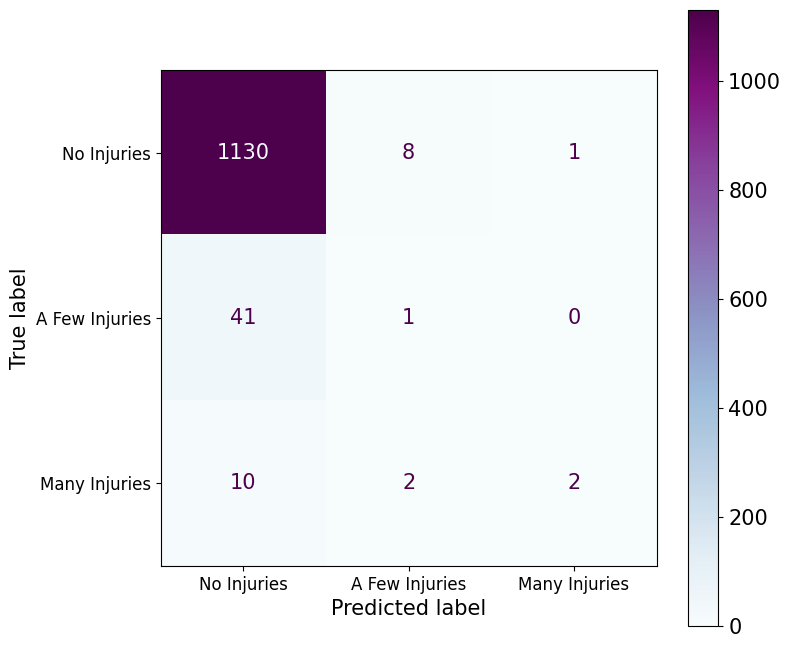

In [37]:
# Decision Tree
# Predictions on test set
y_pred = dt_model_cv.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred, labels = dt_model_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = uniques)

# Specify figure size and font size
fig, ax = plt.subplots(figsize = (8, 8))
plt.rcParams.update({'font.size': 15})
plt.yticks(fontsize = 12) # fontsize of yticks
plt.xticks(fontsize = 12) # fontsize of xticks

# Display Confusion Matrix
disp.plot(cmap = 'BuPu', ax = ax);

fig.savefig("dt_class_matrix.svg", bbox_inches='tight')

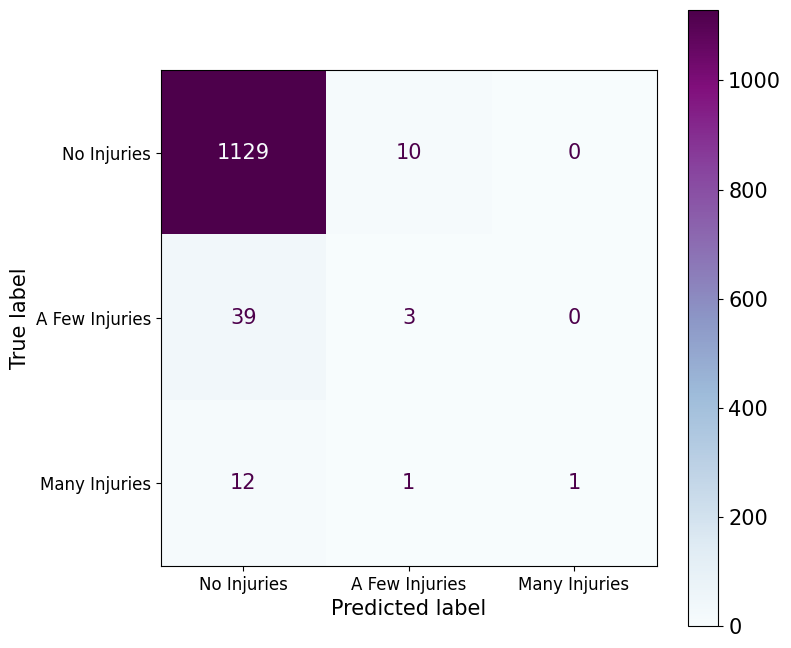

In [83]:
# XG Model
# Predictions on test set
y_pred = xg_model_cv.predict(test_X)

# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred, labels = xg_model_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = uniques)

# Specify figure size and font size
fig, ax = plt.subplots(figsize = (8, 8))
plt.rcParams.update({'font.size': 15})
plt.yticks(fontsize = 12) # fontsize of yticks
plt.xticks(fontsize = 12) # fontsize of xticks

# Display Confusion Matrix
disp.plot(cmap = 'BuPu', ax = ax);

fig.savefig("xg_class_matrix.svg", bbox_inches='tight')

#### Classification Report

In [65]:
# XG Boost
# Generating Classification Report
report = classification_report(test_y, y_pred, output_dict = True, target_names = uniques)
report_df = pd.DataFrame(report)
report_df.to_csv('xg_class_report.csv') 
report_df

,No Injuries,A Few Injuries,Many Injuries,accuracy,macro avg,weighted avg
precision,0.959932,0.300000,0.500000,0.948117,0.586644,0.931349
recall,0.988586,0.142857,0.071429,0.948117,0.400957,0.948117
f1-score,0.974048,0.193548,0.125000,0.948117,0.430866,0.936670
support,1139.000000,42.000000,14.000000,0.948117,1195.000000,1195.000000


In [39]:
# Decision Tree
# Generating Classification Report
y_pred = dt_model_cv.predict(test_X)
report = classification_report(test_y, y_pred, output_dict = True, target_names = uniques)
report_df = pd.DataFrame(report)
report_df.to_csv('dt_class_report.csv') 
report_df


,No Injuries,A Few Injuries,Many Injuries,accuracy,macro avg,weighted avg
precision,0.956816,0.090909,0.666667,0.948117,0.571464,0.922983
recall,0.992098,0.023810,0.142857,0.948117,0.386255,0.948117
f1-score,0.974138,0.037736,0.235294,0.948117,0.415723,0.932571
support,1139.000000,42.000000,14.000000,0.948117,1195.000000,1195.000000


#### Feature Importance

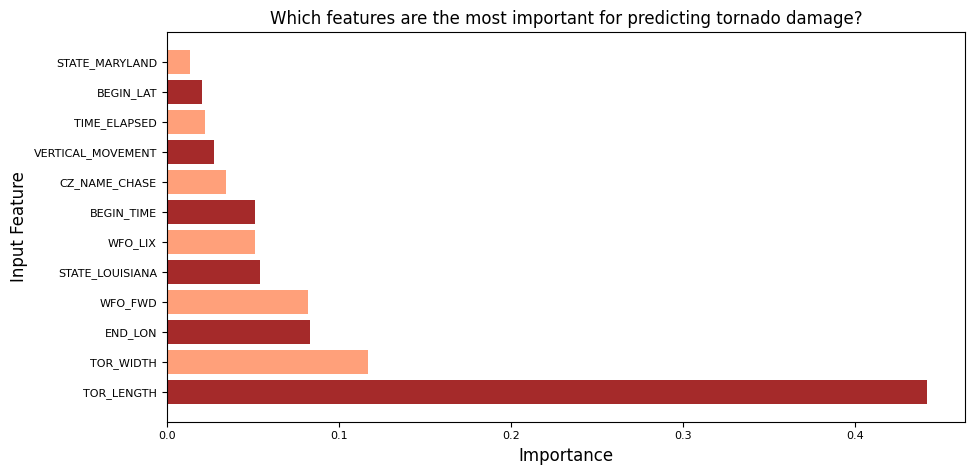

In [67]:
# Decision Tree Feature Importance
# Storing importance values from the trained model
importance = dt_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])
feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Selecting features with non-zero importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.001]

# Bar plot
fig = plt.figure(figsize=(10, 5))
plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color = ['brown', 'lightsalmon'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting tornado damage?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

fig.savefig("dt_feature_imp.svg", bbox_inches='tight')

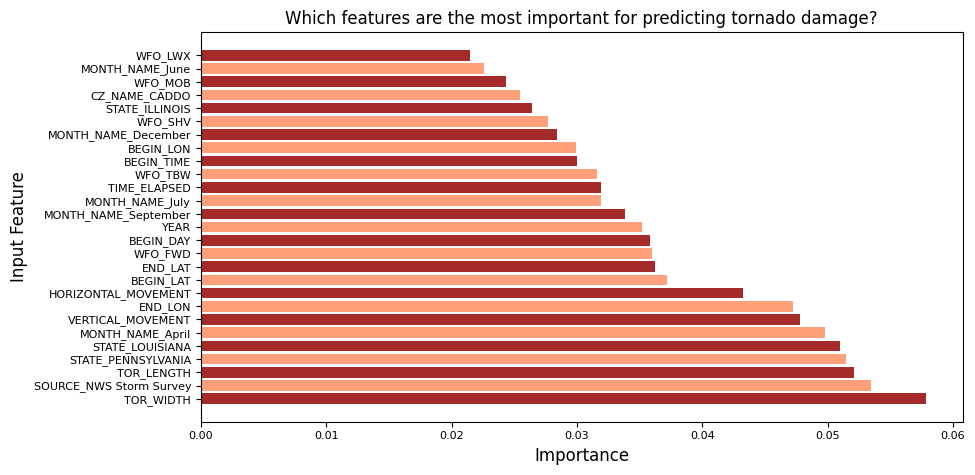

In [68]:
# XG Boost Feature Importance
# Storing importance values from the trained model
importance = xg_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])
feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Selecting features with non-zero importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.001]

# Bar plot
fig = plt.figure(figsize=(10, 5))
plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color = ['brown', 'lightsalmon'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting tornado damage?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

fig.savefig("xg_feature_imp.svg", bbox_inches='tight')

## Pickling Files

In [ ]:
# Pickling the XG model
# Creating the file where we want to write the model
xg_pickle = open('xg_tornados.pickle', 'wb') 

# Write XT model to the file
pickle.dump(bestXG, xg_pickle) 

# Close the file
xg_pickle.close()

In [ ]:
# Pickling the DT model
# Creating the file where we want to write the model
dt_pickle = open('dt_tornados.pickle', 'wb') 

# Write DT model to the file
pickle.dump(bestDT, dt_pickle) 

# Close the file
dt_pickle.close()

In [ ]:
# Picling the uniques mapping 
output_pickle = open('output_tornados.pickle', 'wb') 
pickle.dump(uniques, output_pickle) 
output_pickle.close() 
